# Import

In [221]:
import csv
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# Read CSV

In [222]:
# Read tsv file
r_body  = pd.read_csv('soc-redditHyperlinks-body.tsv', sep='\t')
r_title = pd.read_csv('soc-redditHyperlinks-title.tsv', sep='\t')

r_body

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
...,...,...,...,...,...,...
286556,negareddit,debatefascism,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0..."
286557,mildlynomil,justnomil,68imlas,2017-04-30 04:19:03,1,"2226.0,1855.0,0.786163522013,0.00224618149146,..."
286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"1100.0,909.0,0.778181818182,0.00181818181818,0..."
286559,electricskateboards,askreddit,68ipb2s,2017-04-30 16:41:53,1,"1876.0,1567.0,0.78144989339,0.00692963752665,0..."


In [223]:
r_body_negative = r_body[r_body['LINK_SENTIMENT'] == -1]
r_body_positive = r_body[r_body['LINK_SENTIMENT'] == 1]
r_title_negative = r_title[r_title['LINK_SENTIMENT'] == -1]
r_title_positive = r_title[r_title['LINK_SENTIMENT'] == 1]


r_body_negative
# print(r_title_negative)
# print(r_title_positive)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
34,karmaconspiracy,funny,1u6fz3,2014-01-01 12:44:19,-1,"186.0,182.0,0.741935483871,0.0376344086022,0.0..."
43,badkarma,gamesell,1u6t4g,2014-01-01 16:42:14,-1,"262.0,258.0,0.725190839695,0.0381679389313,0.0..."
53,casualiama,teenagers,1u70s8,2014-01-01 17:09:46,-1,"91.0,91.0,0.78021978022,0.032967032967,0.04395..."
55,australia,sydney,1u71zd,2014-01-01 17:24:46,-1,"2547.0,2158.0,0.801334903808,0.0051040439733,0..."
...,...,...,...,...,...,...
286475,badpolitics,bannedfromthe_donald,68h72b,2017-04-30 11:57:36,-1,"641.0,553.0,0.808112324493,0.00780031201248,0...."
286491,tipofmytongue,deathcore,68hbx9,2017-04-30 12:34:09,-1,"2439.0,2016.0,0.754817548175,0.0069700697007,0..."
286501,soundcloud,procss,68hi5v,2017-04-30 12:16:13,-1,"1053.0,912.0,0.764482431149,0.00569800569801,0..."
286523,enoughtrumpspam,humansbeingbros,68hxu6,2017-04-30 14:25:18,-1,"114.0,114.0,0.701754385965,0.0789473684211,0.0..."


# Function

In [224]:
def gen_dataframe(source,sentiment):
    df = pd.DataFrame()

    df = source[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']]

    # count total number of link_sentiment == sentiment for each subreddit
    df['TOTAL_LINK'] = source.groupby(['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])['LINK_SENTIMENT'].transform(lambda x: (x == sentiment).sum())

    # order dataframe by TOTAL_LINK DESC
    df = df.sort_values(by=['TOTAL_LINK'], ascending=False)

    return df

def difference(df1,df2,column):
    concateneted_df = pd.concat([df1,df2],ignore_index=True)
    merged_df = pd.merge(concateneted_df, concateneted_df,on=[column],how='outer',indicator=True)
    result_df = merged_df[merged_df['_merge'] == 'left_only']
    result_df = result_df.drop(columns='_merge')

    return result_df

def gen_graph(df):
    # Create graph
    G = nx.from_pandas_edgelist(df, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', edge_attr='TOTAL_LINK', create_using=nx.DiGraph())

    # Remove self-loop
    G.remove_edges_from(nx.selfloop_edges(G))

    # Remove nodes with degree 0
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

def gen_plot(G, title):
    # Set layout
    pos = nx.spring_layout(G, k=0.1, iterations=20)

    # Set node size
    node_size = [G.degree(v) * 10 for v in G]

    # Set node color
    node_color = [G.degree(v)  for v in G]

    # Set edge width
    #edge_width = [d['TOTAL_LINK'] / 5 for (u, v, d) in G.edges(data=True)]

    # Set node label
    node_label = {v: v for v in G}

    # Set edge label
    edge_label = {(u, v): d['TOTAL_LINK'] for (u, v, d) in G.edges(data=True)}

    # Set colormap
    cmap = plt.cm.get_cmap('viridis_r')

    # Set figure size
    plt.figure(figsize=(20, 20))

    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=cmap)
    nx.draw_networkx_edges(G, pos, width=1, edge_color='lightgray')
    #nx.draw_networkx_labels(G, pos, labels=node_label, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_label, font_size=8)

    # Set title
    plt.title(title, fontsize=20)

    # Set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(node_color)))
    sm._A = []
    plt.colorbar(sm)

    # Show plot
    plt.show()

def statistics(df):
    #make mean of all the counts
    mean = reddit_negative['TOTAL_LINK'].mean()

    #make median of all the counts
    median = reddit_negative['TOTAL_LINK'].median()

    #make standard deviation of all the counts
    std = reddit_negative['TOTAL_LINK'].std()

    #make variance of all the counts
    var = reddit_negative['TOTAL_LINK'].var()

    #make max of all the counts
    max = reddit_negative['TOTAL_LINK'].max()

    #make min of all the counts
    min = reddit_negative['TOTAL_LINK'].min()

    #make sum of all the counts
    sum = reddit_negative['TOTAL_LINK'].sum()

    #make count of all the counts
    count = reddit_negative['TOTAL_LINK'].count()

    #make mode of all the counts
    mode = reddit_negative['TOTAL_LINK'].mode()

    #count all element of r where count > 10
    r_max10 = reddit_negative[reddit_negative['TOTAL_LINK'] > 10].count() #!516
    
    r_min_eq_10 = reddit_negative[reddit_negative['TOTAL_LINK'] <= 10].count() #!5659

    # print all as table
    print('mean: ', mean)
    print('median: ', median)
    print('std: ', std)
    print('var: ', var)
    print('max: ', max)
    print('min: ', min)
    print('sum: ', sum)
    print('count: ', count)
    print('mode: ', mode)
    print('r_max10: ', r_max10)
    print('r_min10: ', r_min_eq_10)

# Dataframe

In [225]:
reddit_positive = gen_dataframe(r_body_positive,1)  # df with all couple SOURCE TARGET with positive sentiment
reddit_negative = gen_dataframe(r_body_negative,-1) # df with all couple SOURCE TARGET with negative sentiment

/tmp/ipykernel_9436/2293398535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOTAL_LINK'] = source.groupby(['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])['LINK_SENTIMENT'].transform(lambda x: (x == sentiment).sum())
/tmp/ipykernel_9436/2293398535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOTAL_LINK'] = source.groupby(['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])['LINK_SENTIMENT'].transform(lambda x: (x == sentiment).sum())


In [226]:
print(len(reddit_negative))
print(len(reddit_positive))

21070
265491


In [227]:
r_body_source_negative = pd.DataFrame()
r_body_source_negative = r_body_negative['SOURCE_SUBREDDIT']
r_body_source_negative = r_body_source_negative.reset_index()
r_body_source_negative = r_body_source_negative.value_counts()
r_body_source_negative = r_body_source_negative.reset_index()
print(r_body_source_negative)

r_body_target_negative = pd.DataFrame()
r_body_target_negative = r_body_negative['TARGET_SUBREDDIT']
r_body_target_negative = r_body_target_negative.reset_index()
r_body_target_negative = r_body_target_negative.value_counts()
r_body_target_negative = r_body_target_negative.reset_index()
print(r_body_target_negative)

source_negative = r_body_source_negative.merge(r_body_target_negative,how = 'outer',indicator=True).loc[lambda x: x['_merge'] == 'left_only']
target_negative = r_body_source_negative.merge(r_body_target_negative,how = 'outer',indicator=True).loc[lambda x: x['_merge'] == 'right_only']
hub_negative = r_body_source_negative.merge(r_body_target_negative,how = 'outer',indicator=True).loc[lambda x: x['_merge'] == 'both']


source_negative = source_negative.reset_index()
target_negative = target_negative.reset_index()
hub_negative = hub_negative.reset_index()

for i in range(len(source_negative)):
    if source_negative['index'][i] in r_body_target_negative['index'].values:
        print('yes')
        print(source_negative['index'][i])

for i in range(len(target_negative)):
    if target_negative['index'][i] in r_body_source_negative['index'].values:
        print('yes')
        print(target_negative['index'][i])


for i in range(len(source_negative)):
    for j in range(len(target_negative)):
        if(source_negative['index'][i] == target_negative['index'][j]):
            print('error')
            print(source_negative['index'][i])
            break

for i in range(len(source_negative)):
    for j in range(len(target_negative)):
        found = 0;
        if(source_negative['index'][i] == target_negative['index'][j]):
            found = 1
            break
    if found == 0:
        print('error')
        print(source_negative['index'][i])
        break



        index      SOURCE_SUBREDDIT  0
0           1            theredlion  1
1      191122        subredditdrama  1
2      191045          windowsphone  1
3      191042  bestofoutrageculture  1
4      191011             xxfitness  1
...       ...                   ... ..
21065   95030        subredditdrama  1
21066   95029      purplepilldebate  1
21067   95026        subredditdrama  1
21068   95022        destructionist  1
21069  286554        subredditdrama  1

[21070 rows x 3 columns]
        index       TARGET_SUBREDDIT  0
0           1                 soccer  1
1      191122  againsthatesubreddits  1
2      191045             3dprinting  1
3      191042               trackers  1
4      191011                fitness  1
...       ...                    ... ..
21065   95030                    nyc  1
21066   95029            thebluepill  1
21067   95026     twitchplayspokemon  1
21068   95022           unitedcolors  1
21069  286554                  funny  1

[21070 rows x 3 columns]


# Statistics

In [228]:
statistics(reddit_negative)
#statistics(reddit_positive)

mean:  3.9453251067869006
median:  1.0
std:  7.155093206826703
var:  51.19535879837763
max:  56
min:  1
sum:  83128
count:  21070
mode:  0    1
Name: TOTAL_LINK, dtype: int64
r_max10:  SOURCE_SUBREDDIT    1790
TARGET_SUBREDDIT    1790
TOTAL_LINK          1790
dtype: int64
r_min10:  SOURCE_SUBREDDIT    19280
TARGET_SUBREDDIT    19280
TOTAL_LINK          19280
dtype: int64


# Graph visualization

## Negative sentiment

TypeError: 'numpy.int64' object is not callable

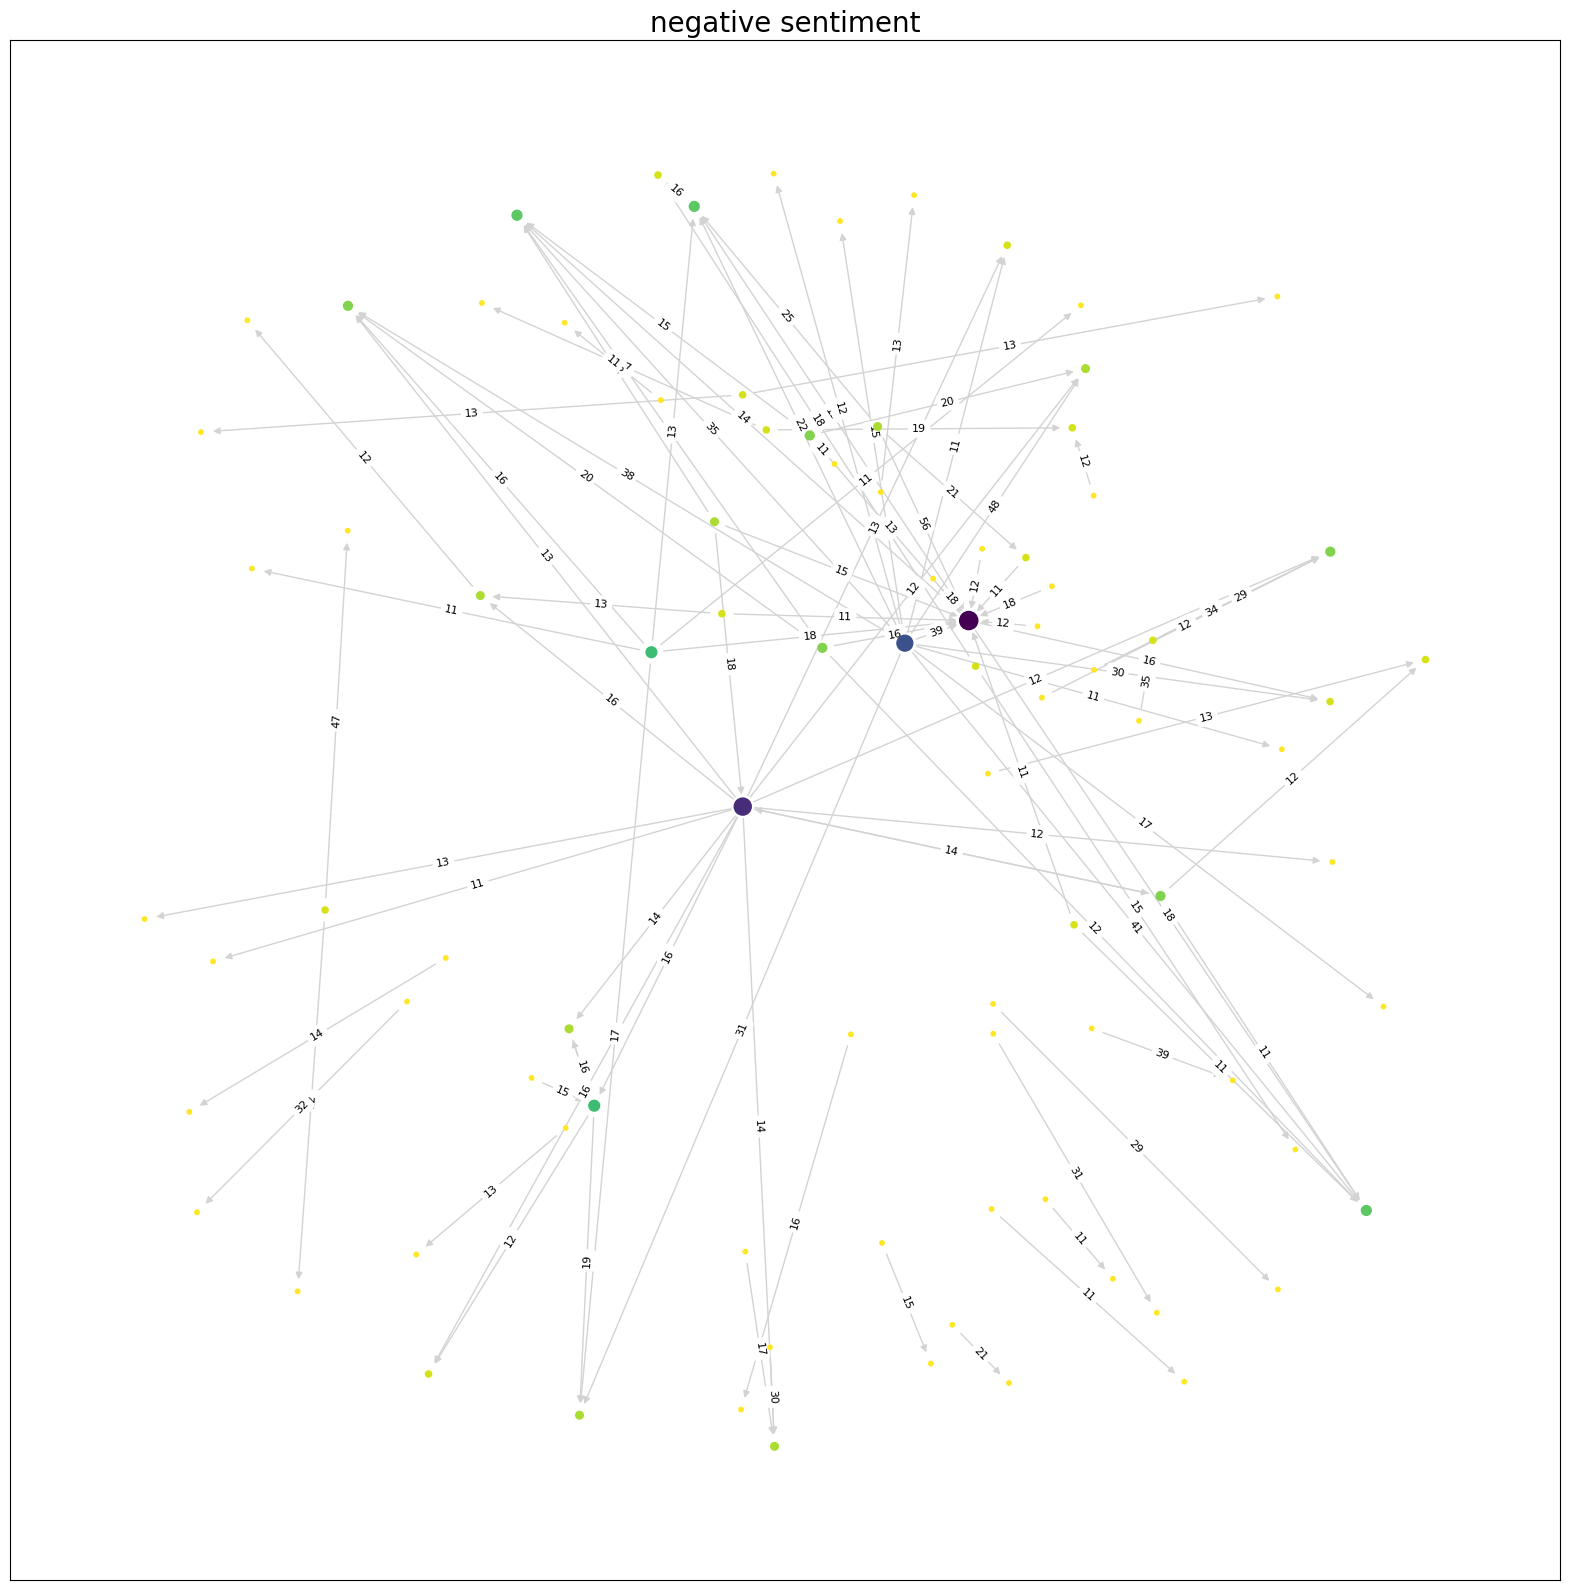

In [229]:
G_negative = gen_graph(reddit_negative[reddit_negative['TOTAL_LINK'] > 10])
gen_plot(G_negative,'negative sentiment')


## Positive sentiment

In [ ]:
G_positive = gen_graph(reddit_positive[reddit_positive['TOTAL_LINK'] > 10])
gen_plot(G_positive,'positive sentiment')


In [ ]:
# print the first 5 rows of the dataframe
print(r_body.head())

# count all the multi edges
print(r_body.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']).size().reset_index(name='count').sort_values('count', ascending=False))

In [ ]:
# show rows where link_sentiment is -1 (negative) and group by subreddit and count the number of rows
r = r_body[r_body['LINK_SENTIMENT'] == -1].groupby('SOURCE_SUBREDDIT')['LINK_SENTIMENT'].count()

# order by count
r = r.sort_values(ascending=False)
r

In [ ]:
# show rows where link_sentiment is -1 (negative) and group by subreddit and count the number of rows
r = r_title[r_title['LINK_SENTIMENT'] == -1].groupby('SOURCE_SUBREDDIT')['LINK_SENTIMENT'].count()

# order by count
r = r.sort_values(ascending=False)

In [ ]:
#Create Graph where nodes are SOURCE_SUBREDDIT and edges are LINK_SENTIMENT == -1
# G = nx.from_pandas_edgelist(r_body[r_body['LINK_SENTIMENT'] == 1], 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', create_using=nx.DiGraph())


# print(G.number_of_edges())
# print(G.number_of_nodes())
# # seed = 13648  # Seed random number generators for reproducibility
# # pos = nx.spring_layout(G, seed=seed)

# # node_sizes = [3 + 10 * i for i in range(len(G))]
# # M = G.number_of_edges()
# # edge_colors = range(2, M + 2)
# # edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
# # cmap = plt.cm.plasma

# # nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
# # edges = nx.draw_networkx_edges(
# #     G,
# #     pos,
# #     node_size=node_sizes,
# #     arrowstyle="->",
# #     arrowsize=10,
# #     edge_color=edge_colors,
# #     edge_cmap=cmap,
# #     width=2,
# # )
# # # set alpha value for each edge
# # for i in range(M):
# #     edges[i].set_alpha(edge_alphas[i])

# # pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# # pc.set_array(edge_colors)

# # ax = plt.gca()
# # ax.set_axis_off()
# # plt.colorbar(pc, ax=ax)
# # plt.show()

# # Use a spring layout to arrange the nodes
# pos = nx.spring_layout(G)

# # Set the figure size
# plt.figure(figsize=(20,20))

# # Draw the graph
# nx.draw(G, pos, with_labels=False, node_size=10, alpha=0.5)

# # Add labels to the nodes
# labels = nx.get_node_attributes(G, 'label')
# nx.draw_networkx_labels(G, pos, labels)

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()
